## The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2020 Semester 2
-----
## Project 1: Predicting stroke with Naive Bayes and K-NN
-----
#### Student Name(s): Zhihao Huang
#### Student ID: 1052452
#### Python version: 3.7.7
#### Submission deadline: 

This iPython notebook is a template which you will use for your Project 1 submission. 

Marking will be applied on the functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math

In [25]:
# This function should transform data into a usable format 
def preprocess():
    filename = 'stroke_update.csv'
    dataset = pd.read_csv(filename)
    return dataset

    

In [26]:
X_df = preprocess()[['avg_glucose_level', 'bmi', 'age', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]
Y_df = preprocess()['stroke']

In [27]:
X_df

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,137.45,26.0,53,Male,0,0,Yes,Self-employed,Rural,smokes
1,56.85,24.4,44,Female,0,0,Yes,Private,Rural,never smoked
2,87.79,41.1,49,Female,0,0,No,Private,Urban,never smoked
3,94.82,22.9,28,Female,0,0,No,Private,Urban,never smoked
4,96.80,29.6,73,Male,0,0,Yes,Private,Urban,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
2735,88.29,36.0,79,Male,0,1,Yes,Self-employed,Urban,never smoked
2736,93.38,26.7,76,Male,0,0,Yes,Self-employed,Rural,formerly smoked
2737,83.27,32.9,56,Female,0,0,Yes,Private,Rural,smokes
2738,75.91,26.7,80,Female,0,0,Yes,Self-employed,Urban,never smoked


In [28]:
Y_df

0       0
1       0
2       0
3       0
4       0
       ..
2735    1
2736    1
2737    1
2738    1
2739    1
Name: stroke, Length: 2740, dtype: int64

In [29]:
Y_df.value_counts()

0    2192
1     548
Name: stroke, dtype: int64

In [30]:
def show_relations(x_var, y_var, dataset):
    xs = []
    ys = []
    dataset = dataset.groupby(x_var)
    list(dataset).sort()
    for grouper, groupee in dataset:
        xs.append(grouper)
        ys.append(groupee[y_var].mean())
    plt.plot(xs, ys)
    plt.title(x_var + ' vs. ' + y_var)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()


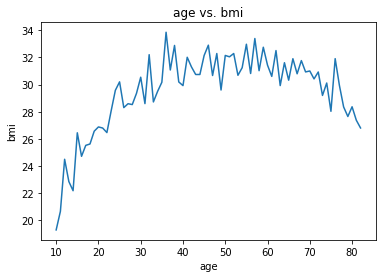

In [31]:
show_relations('age', 'bmi', X_df)

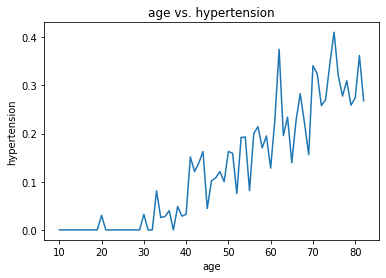

In [32]:
show_relations('age', 'hypertension',X_df)

### Question 1: Data exploration

- a) Explore the data and summarise different aspects of the data. Can you see any interesting characteristic in features, classes or categories? What is the main issue with the data? Considering the issue, how would the Naive Bayes classifier work on this data? Discuss your answer based on the Naive Bayes' formulation.

    In raw dataset, all the class labeled as  *No stroke* are arranged together, completely seperated from the class label as *Having stroke*, which means data is sorted by their classes. We should shuffle it to make sure our training/testing/validation sets are representative of the overall distribution of the data. And some features are highly dependent on others, such as *Age vs. Hypertension*, *Age vs. BMI*, etc. It will significantly violate the independent assumption Naive Bayes Classifier makes, and because of this, the result could be potentially bad.
    
    After having an observation of the given dataset, we found that the main issue with the data is that there is an imbalance distribution in the size of each class. As *No stroke* is four times as many as *Having stroke*, so that the prior probability $P(y)$ of *No stroke* would much larger than *Having stroke*'s. And because Naive Bayes classifier would pick the class that maximizes the posterior probability, highly imbalanced prior probability may easily lead to Naive Bayes classifier making majority-inclined predcition. So that in this case, NB classifier would be more likely predict *Having stroke* as *No stroke*, which may be a severe medical fault.
     
    $$
    \begin{aligned}
    P\left(x_{1}, x_{2}, \ldots, x_{M} \mid y\right) P(y) & \approx P\left(x_{1} \mid y\right) P\left(x_{2} \mid y\right) \ldots P\left(x_{M} \mid y\right) P(y) \\
    &=P(y) \prod_{m=1}^{M} P\left(x_{m} \mid y\right)
    \end{aligned}
    $$

    $$
    \begin{aligned}
    \hat{y}=\underset{y \in Y}{\operatorname{argmax}} P\left(x_{1}, x_{2}, \ldots, x_{M} \mid y\right) P(y)
    \end{aligned}
    $$

    
---

- b) Is accuracy an appropriate metric to evaluate the models created for this data? Justify your answer. Explain which metric(s) would be more appropriate, and contrast their utility against accuracy. [no programming required]

    I don't think accuracy is the most appropriate metric to evaluate the models created for this data, although it is the most intuitive performance measure. Accuracy could be great only when we have symmetric dataset where the number of false positive and false negative are almost same. Let's label *Having stroke* as **Positive** and lable *No stroke* as **Negetive**. We know that $Accuracy=\frac{TP + TN}{TP + FP + FN + TN}$. A model could only predict **Negetive** may also achieve high accuracy, because in the real world, people having stroke are the minority, leading *FN* becomes far way smaller than *TN*. However, the cost of *FN* (i.e., telling a patient who might suffer from stroke he/she is totally fine) is really high, the symptoms of stroke are usually permanent.  We need to reduce the probibility of *FN*; therefore, I would suggest that using *Recall*, where $Recall = \frac{TP}{TP + FN}$,  as the most important metric in evaluation. Also, *Accuracy* is a good method to select a best model when we have tie on using *Recall* to compare models.

In [33]:
X_df['avg_glucose_level'] = pd.cut(X_df['avg_glucose_level'], bins = 128)
X_df['bmi'] = pd.cut(X_df['bmi'], bins = 64)
X_df['age'] = pd.cut(X_df['age'], bins = 64)

X_df

,avg_glucose_level,bmi,age,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status
0,"(136.284, 137.977]","(25.825, 26.752]","(52.75, 53.875]",Male,0,0,Yes,Self-employed,Rural,smokes
1,"(56.703, 58.396]","(23.972, 24.898]","(43.75, 44.875]",Female,0,0,Yes,Private,Rural,never smoked
2,"(87.181, 88.874]","(40.65, 41.577]","(48.25, 49.375]",Female,0,0,No,Private,Urban,never smoked
3,"(93.954, 95.647]","(22.119, 23.045]","(26.875, 28.0]",Female,0,0,No,Private,Urban,never smoked
4,"(95.647, 97.34]","(29.531, 30.458]","(71.875, 73.0]",Male,0,0,Yes,Private,Urban,formerly smoked
...,...,...,...,...,...,...,...,...,...,...
2735,"(87.181, 88.874]","(35.091, 36.017]","(78.625, 79.75]",Male,0,1,Yes,Self-employed,Urban,never smoked
2736,"(92.26, 93.954]","(25.825, 26.752]","(75.25, 76.375]",Male,0,0,Yes,Self-employed,Rural,formerly smoked
2737,"(82.101, 83.794]","(32.311, 33.238]","(55.0, 56.125]",Female,0,0,Yes,Private,Rural,smokes
2738,"(75.328, 77.022]","(25.825, 26.752]","(79.75, 80.875]",Female,0,0,Yes,Self-employed,Urban,never smoked


In [34]:
# This function should split a data set into a training set and hold-out test set
from sklearn.model_selection import train_test_split
def split_data(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    return X_train, X_test, Y_train, Y_test

In [35]:
X_train, X_test, Y_train, Y_test = split_data(X_df, Y_df)
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()
Y_train = Y_train.values.tolist()
Y_test = Y_test.values.tolist()

In [36]:
def p_y(y):
    class_priors = [0]*len(set(y))
    for c in y:
        class_priors[c]+=1    
    return class_priors

In [37]:
# Function for likelihood p(x=j|y=i) = n(i,j)/n(i)
def p_xy(x,y):
    
    # init dict (over classes) of dict (over features) of dict (over value counts)
    outdict = {c:{} for c in y}
    for d in outdict.keys():
        for f in range(len(x[0])):
            outdict[d][f]={}
            rng = set([i[f] for i in x])
            outdict[d][f] = {v:0 for v in rng}
    
      
    # fill dict with counts
    for idx,_ in enumerate(x):
        for fidx, _ in enumerate(x[idx]):
            outdict[y[idx]][fidx][x[idx][fidx]]+=1
           
    # # normalize, or fill in epsilons as needed
    for cl in outdict.keys():
        for f in outdict[cl].keys():
            for val in outdict[cl][f]:
                outdict[cl][f][val] = (outdict[cl][f][val] + 1) / (p_y(y)[cl] + len(outdict[cl][f]))
            
    return outdict


In [38]:
def cnb_train(x,y):
    py = p_y(y)
    pxy = p_xy(x,y)
    return py, pxy

In [39]:
py,pxy = cnb_train(X_train, Y_train)

In [40]:
# Function for predicting test labels
def cnb_predict(x, pc, pxc):
    # sums up prior and independent likelihood terms
    class_probs = []
    for y in range(len(pc)):
        class_prob=pc[y]/sum(pc)
        for fidx, f in enumerate(x):
            if f in pxc[y][fidx]:
                class_prob = class_prob * pxc[y][fidx][f]
        class_probs.append(class_prob)
    return class_probs, np.argmax([class_probs])

In [41]:
# This function should evaluate a set of predictions in terms of metrics
from sklearn import metrics
def evaluate(pred,true):
    CM = metrics.confusion_matrix(true, pred) # Confusion Matrix
    Acc = metrics.accuracy_score(true, pred) # Accuracy
    precf1 = metrics.precision_recall_fscore_support(true, pred, zero_division=1,labels=[0,1]) # Precision, Recall and F1-score
    return CM, Acc, precf1

In [42]:
# Categorical Naive Bayes implementation
# predict on train
print("\nevaluation using training data")

correct = 0
preds = []
for i in range(len(X_train)):
    prediction = cnb_predict(X_train[i], py, pxy)[1]
    correct = correct + int(prediction==Y_train[i])
    preds.append(prediction)
# print(preds)

CM, Acc, precf1 = evaluate(preds, Y_train)

print("Confusion Matrix:\n{}\naccuracy: {}\naccuracy by sklearn.metric: {}\nprecision: {}\nrecall: {}\nF1: {}".format(CM,
                                                correct / len(X_train), 
                                                Acc,
                                                precf1[0],
                                                precf1[1],
                                                precf1[2]))

# predict on test
print("\nevaluation using test data")

correct = 0
preds = []
for i in range(len(X_test)):
    prediction = cnb_predict(X_test[i], py, pxy)[1]
    correct = correct + int(prediction==Y_test[i])
    preds.append(prediction)      
CM, Acc, precf1 = evaluate(preds, Y_test)

print("Confusion Matrix:\n{}\naccuracy: {}\naccuracy by sklearn.metric: {}\nprecision: {}\nrecall: {}\nF1: {}".format(CM, 
                                                correct / len(X_test), 
                                                Acc,
                                                precf1[0],
                                                precf1[1],
                                                precf1[2]))


evaluation using training data
Confusion Matrix:
[[1376  167]
 [ 191  184]]
accuracy: 0.8133472367049009
accuracy by sklearn.metric: 0.8133472367049009
precision: [0.87811104 0.52421652]
recall: [0.89176928 0.49066667]
F1: [0.88488746 0.50688705]

evaluation using test data
Confusion Matrix:
[[559  90]
 [ 93  80]]
accuracy: 0.7773722627737226
accuracy by sklearn.metric: 0.7773722627737226
precision: [0.85736196 0.47058824]
recall: [0.86132512 0.46242775]
F1: [0.85933897 0.4664723 ]


In [43]:
# Zero-R implementation
# predict on train
print("\nevaluation using training data")

correct = 0
preds = []
for i in range(len(X_train)):
    prediction = 0
    correct = correct + int(prediction==Y_train[i])
    preds.append(prediction)

CM, Acc, precf1 = evaluate(preds, Y_train)

print("Confusion Matrix:\n{}\naccuracy: {}\naccuracy by sklearn.metric: {}\nprecision: {}\nrecall: {}\nF1: {}".format(CM,
                                                correct / len(X_train), 
                                                Acc,
                                                precf1[0],
                                                precf1[1],
                                                precf1[2]))

# predict on test
print("\nevaluation using test data")

correct = 0
preds = []
for i in range(len(X_test)):
    prediction = 0
    correct = correct + int(prediction==Y_test[i])
    preds.append(prediction)      
CM, Acc, precf1 = evaluate(preds, Y_test)

print("Confusion Matrix:\n{}\naccuracy: {}\naccuracy by sklearn.metric: {}\nprecision: {}\nrecall: {}\nF1: {}".format(CM, 
                                                correct / len(X_test), 
                                                Acc,
                                                precf1[0],
                                                precf1[1],
                                                precf1[2]))


evaluation using training data
Confusion Matrix:
[[1543    0]
 [ 375    0]]
accuracy: 0.8044838373305526
accuracy by sklearn.metric: 0.8044838373305526
precision: [0.80448384 1.        ]
recall: [1. 0.]
F1: [0.89164981 0.        ]

evaluation using test data
Confusion Matrix:
[[649   0]
 [173   0]]
accuracy: 0.7895377128953771
accuracy by sklearn.metric: 0.7895377128953771
precision: [0.78953771 1.        ]
recall: [1. 0.]
F1: [0.88239293 0.        ]


### Question 2: Naive Bayes concepts and formulation

- a) Explain the independence assumption underlying Naive Bayes. What are the advantages and disadvantages of this assumption? Elaborate your answers using the features of the provided data. [no programming required

    **Advantages**:

- *Simplicity and Efficiency* Having independence assumption makes Naive Bayes much easier to understand and to be implemented. And independence assumption also significantly reduce the number of conditional distribution, speeding up the whole learning and precition process. In this case, some features are dependent on others. If we use a model fully based on actual condictional probability distribution rather than assuming that features are mutually independent, the whole process would be far more complicated and time-consuming, and the model may also have high variance.

- *Easily dealing with missing/extra features* When making an interference on a new instance with missing features or with extra features. With independence assumption and chain rule, we could drop the missing feature uniformly for all classes or drop the extra feature for the new instance without dropping any instance. For example, say we take a mountain of data from data warehouse to predict the probability of those people having stroke, it may probably that some instances miss some features or have extra features, i.e., the data we get is very likely unorganized. In this way, data is much easier to be preproceeded.

    **Disadvantages**:

- Naive Bayes classifier strongly assumes that that all features in $X$ are mutually independent. Once tha shape of our data distribution violates this assumption, the performace of the model could be potentially bad. Unfortunately, our data is far away from the assumption.

---

- b) Implement the Naive Bayes classifier. You need to decide how you are going to apply Naive Bayes for nominal and numeric attributes. You can combine both Gaussian and Categorical Naive Bayes (option 1) or just using Categorical Naive Bayes (option 2). Explain your decision. For Categorical Naive Bayes, you can choose either epsilon or Laplace smoothing for this calculation. Evaluate the classifier using accuracy and appropriate metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.

    Just using Categorical Naive Bayes is much easier to implement. And there are only 3 out of 10 features are continous numeric data, I guess the outcome of combining both Gaussian and Categorical Naive Bayes should be similar as onlu using Categorical Naive Bayes. Therefore, I choose option 2. And I choose Laplace smoothing for this calculation.
    
    The *Recall* of traning data is always lager than the recall of test data. What's more, the accuracy of traning data is also larger than the accuracy of test data, but they are quite close. Categorical Naive Bayes and Zero-R has similar accuracy. But Zero-R cannot evaluted by *Recall* and *F1* of the class *Having stroke*, because it always predicts that people won't have a stroke. By contrast, we could evaluate CNB with *Recall* appropriately. And because our goal is to make efforts to find out potential patients, we care more about *Recall* than accuracy. 

--- 

- c) Explain the difference between epsilon and Laplace smoothing. [no programming required]

    In *epsilon smoothing*, we set those features with $P(x_i|y) = 0$ as $P(x_i|y)=\epsilon$, and $\epsilon$ should be quite small that we could assume $1+\epsilon\approx1$;
    
    In *Laplace smoothing*, we add "pseudocount" $\alpha$ to each feature count observed during training, and usually set $\alpha$ to 1. $P\left(x_{m}=j \mid y=k\right)=\frac{\alpha+\operatorname{count}\left(y=k, x_{m}=j\right)}{M \alpha+\operatorname{count}(y=k)}$, where M equals to the number of distinct values of $x_m$


## K-NN

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import KFold

In [45]:
# Pre-process for data
X_df = preprocess()[['avg_glucose_level', 'bmi', 'age', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]
Y_df = preprocess()['stroke']
X_df['avg_glucose_level'] = pd.cut(X_df['avg_glucose_level'], bins = 128)
X_df['bmi'] = pd.cut(X_df['bmi'], bins = 64)
X_df['age'] = pd.cut(X_df['age'], bins = 64)
columns = ['avg_glucose_level', 'bmi', 'age', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_df = pd.get_dummies(X_df, columns=columns)

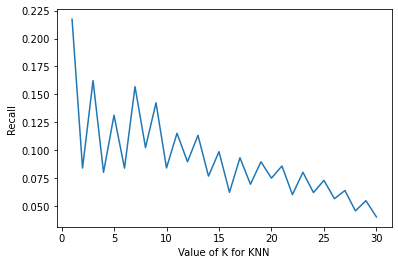

In [46]:
# Choose best K for K-NN by recall
def knn_recall(X_df, Y_df):
    k_score = []
    k_range = range(1,31)
    for k in k_range:
        classifier = KNeighborsClassifier(k)
        scores = cross_val_score(classifier, X_df, Y_df, cv=10, scoring='recall')
        k_score.append(scores.mean())
    plt.plot(k_range, k_score)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Recall')
    plt.show()

knn_recall(X_df, Y_df)

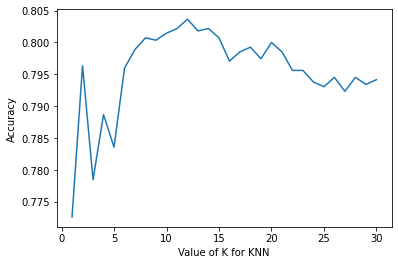

In [47]:
# Choose best K for K-NN by accuracy
def knn_acc(X_df, Y_df):
    k_score = []
    k_range = range(1,31)
    for k in k_range:
        classifier = KNeighborsClassifier(k)
        scores = cross_val_score(classifier, X_df, Y_df, cv=10, scoring='accuracy')
        k_score.append(scores.mean())
    plt.plot(k_range, k_score)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Accuracy')
    plt.show()

knn_acc(X_df, Y_df)

In [48]:
# K-NN implementation
def knn_pred(X_df, Y_df):
    Accs = []
    precs = []
    recalls = []
    f1s = []
    kf = KFold(n_splits = 10, shuffle=True)
    for train_idex, test_index in kf.split(X_df):
        X_train, X_test = X_df.iloc[train_idex], X_df.iloc[test_index]
        Y_train, Y_test = Y_df.iloc[train_idex], Y_df.iloc[test_index]
        classifier = KNeighborsClassifier(n_neighbors=1)
        classifier.fit(X_train, Y_train)
        preds = classifier.predict(X_test)
        CM, Acc, precf1 = evaluate(preds, Y_test)
        print("Confusion Matrix:\n{}\naccuracy: {}\nprecision: {}\nrecall: {}\nF1: {}".format(CM, Acc, precf1[0], precf1[1], precf1[2]))
        Accs.append(Acc)
        precs.append(precf1[0][1])
        recalls.append(precf1[1][1])
        f1s.append(precf1[2][1])
        
    print("\nAccs -> " + str(np.mean(Accs)))
    print("Class 1 Prec -> " + str(np.mean(precs)))
    print("Class 1 Recall -> " + str(np.mean(recalls)))
    print("Class 1 F1 -> " + str(np.mean(f1s)))

knn_pred(X_df, Y_df)

Confusion Matrix:
[[197  23]
 [ 43  11]]
accuracy: 0.7591240875912408
precision: [0.82083333 0.32352941]
recall: [0.89545455 0.2037037 ]
F1: [0.85652174 0.25      ]
Confusion Matrix:
[[207  19]
 [ 39   9]]
accuracy: 0.7883211678832117
precision: [0.84146341 0.32142857]
recall: [0.9159292 0.1875   ]
F1: [0.87711864 0.23684211]
Confusion Matrix:
[[198  22]
 [ 43  11]]
accuracy: 0.7627737226277372
precision: [0.82157676 0.33333333]
recall: [0.9       0.2037037]
F1: [0.85900217 0.25287356]
Confusion Matrix:
[[205  20]
 [ 41   8]]
accuracy: 0.7773722627737226
precision: [0.83333333 0.28571429]
recall: [0.91111111 0.16326531]
F1: [0.87048832 0.20779221]
Confusion Matrix:
[[196  18]
 [ 49  11]]
accuracy: 0.7554744525547445
precision: [0.8        0.37931034]
recall: [0.91588785 0.18333333]
F1: [0.8540305  0.24719101]
Confusion Matrix:
[[199  23]
 [ 42  10]]
accuracy: 0.7627737226277372
precision: [0.82572614 0.3030303 ]
recall: [0.8963964  0.19230769]
F1: [0.85961123 0.23529412]
Confusion Matr

### Question 3: Model Comparison
- a) Implement the K-NN classifier, and find the optimal value for K.  

When K equals to 1, the classifier has highest recall. As mentioned above, *Recall* is the prime metric we consider.  
---  
- b) Based on the obtained value for K in question 4 (a), evaluate the classifier using accuracy and chosen metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.  

Precision , recall and F1 of class *No stroke* are overwhelmingly larger than those of class *Having stroke*, respectively. I think it is because the number of instance labeled as *No stroke* is four times as larger as the number of instance labeled as *Having stroke*. And because of the nature of K-NN, if a specific class occurs frequently in the training set then it is most likely to dominate the majority voting of the new instance.  In this point, the result of K-NN is similar with the outcome of Zero-R, because both of them are significantly affected by the size of each class. I guess whether we should know the number of each class at the very beginning. If there is an imbalance in the number of each class, then we should resample our corresponded classes by amplifying them or dropping some instances but carefully retain the same distribution.  
---  
- c) Compare the classifiers (Naive Bayes and K-NN) based on metrics' results. Provide a comparatory discussion on the results. [no programming required]  

Naive Bayes achieves higer accuracy than K-NN does, but the gap is small, both of their accuracy are around 0.8. Naive Bayes shows higher Recall than KNN for class *Having stroke* but shows lower recall than KNN for class *No stroke*. As for other evaluation metrics, Naive Bayes and KNN show similar outcomes. In this dataset, the number of  *No stroke* is 4 times as many as the number of *Having stroke*. The imbalance data distribution may significantly affect the performance of K-NN.   
One more interesting thing is that because we apply `get_dummies()` function to the data, without suprise, it inflates the dimension of the data. The performance of K-NN should deteriorate with high-dimension data as there is hardly any difference between the nearest and farthest neighbor. However, it seems like K-NN isn't affected not that much in terms of *Accuracy*, because the nature that KNN tending to classify a new instance as the majority (*No stroke* in this case) matches the distribution in the real world.  
As we choose *Recall* as the most appropriate metric, Naive Bayes outperforms K-NN in this case.